<a href="https://colab.research.google.com/github/ninayang2019/Machine-Learning/blob/master/6sense_take_home(_Nina_Yang)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Ingest modules and data preperation


In [0]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Importing model helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from yellowbrick.classifier import ConfusionMatrix


In [0]:
df=pd.read_csv('training.tsv',delimiter='\t',encoding='utf-8',header=None)
df.columns = ['ID', 'Date','Event'] #Assign header to dataframe
df.head(10)
df.isnull().any() #check null value

In [29]:
# Get a new dataframe groupby ID
GroupKey='ID'
Date = 'Date'
Event = 'Event'
Event_Steps = ['EmailOpen','EmailClickthrough','FormSubmit','WebVist','PageView','Purchase']

def funnelize (group, Event_Steps):
    curr = 0
    cnts = [0 for s in Event_Steps]
 
    for i,row in group.iterrows():
        event = row[Event]
        if event in Event_Steps:
            idx = Event_Steps.index(event)
            cnts[idx] +=1
    return cnts

df.sort_values(by=Date,ascending=True, inplace=True)
Event_Cnts = df.groupby(GroupKey).apply(funnelize,Event_Steps)
NewTrain = pd.DataFrame(list(Event_Cnts.values),index = Event_Cnts.index,columns = Event_Steps)
NewTrain.head(10)

,EmailOpen,EmailClickthrough,FormSubmit,WebVist,PageView,Purchase
ID,,,,,,
00002acbe042d69,9,0,1,0,0,0
0000a3a34bd07e6,20,0,0,0,0,0
0000ecf58c94668,11,1,1,0,0,6
00012205dd4613b,2,0,0,0,0,0
000198d39a568cf,0,0,0,0,0,1
0001b315b991cf0,1,0,0,0,0,0
00022618457fcf2,0,0,0,0,0,1
000256826de4432,0,0,0,0,0,1
000269150971d08,3,0,0,0,0,0


In [31]:
# Add a new column as target. 
NewTrain['Target'] = np.where(NewTrain['Purchase']>=1,1, 0)
Train = NewTrain.sample(frac=0.7) # Spilit current train dataset to 7:3
Test = NewTrain.loc[~NewTrain.index.isin(Train.index)]
#Get matrix
Train = Train.as_matrix()
Test = Test.as_matrix()
XTr = Train[:,:-2]
YTr = Train[:,-1]
XTe = Test[:,:-2]
YTe = Test[:,-1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


## Modeling

In [32]:
#Logistic Regression
model = LogisticRegression()
model.fit(XTr, YTr)
print(model)
predicted = model.predict(XTe)
expected = YTe
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
#accuracy score
LR_accy_train = round(model.score(XTr,YTr),2)
LR_accy = round(model.score(XTe,YTe),2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     71282
           1       0.76      0.02      0.04     31188

    accuracy                           0.70    102470
   macro avg       0.73      0.51      0.43    102470
weighted avg       0.72      0.70      0.59    102470

[[71055   227]
 [30479   709]]


In [34]:
#Random Forest
forest = RandomForestClassifier(n_estimators = 100)
forest = forest.fit(XTr,YTr)
output = forest.predict(XTe)
output
pd.crosstab(YTe, output, rownames=['actual'], colnames=['preds'])
#accuracy score
RF_accy_train = round(forest.score(XTr,YTr),2)
RF_accy = round(forest.score(XTe,YTe),2)

preds,0,1
actual,,
0,69404,1878
1,9789,21399


In [0]:
from yellowbrick.classifier import ConfusionMatrix

In [0]:
#XG Boost
xgb = XGBClassifier()
xgb.fit(XTr,YTr)

y_pred = xgb.predict(XTe)
xgb_accy_train = round(xgb.score(XTr,YTr),2)
xgb_accy = round(xgb.score(XTe,YTe),2)


## Model Evaluation

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


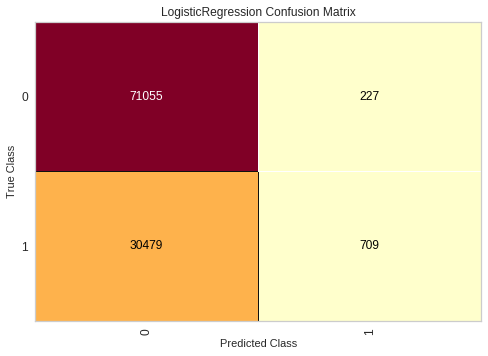

In [53]:
cm_LR = ConfusionMatrix(model, classes=[0,1])
cm_LR.fit(XTr,YTr)
cm_LR.score(XTe,YTe)
cm_LR.poof()

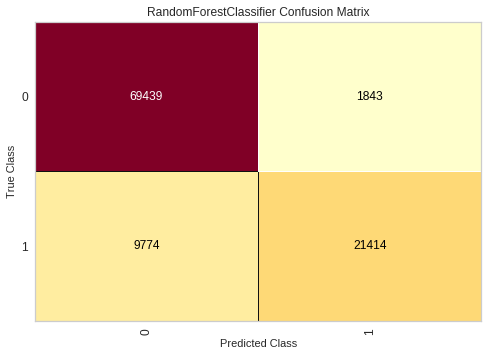

In [54]:
cm_RF = ConfusionMatrix(forest, classes=[0,1])
cm_RF.fit(XTr,YTr)
cm_RF.score(XTe,YTe)
cm_RF.poof()

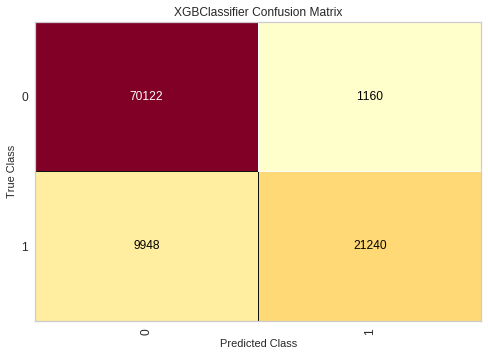

In [55]:
cm_xgb = ConfusionMatrix(xgb, classes=[0,1])
cm_xgb.fit(XTr,YTr)
cm_xgb.score(XTe,YTe)
cm_xgb.poof()

In [51]:
print('Accuracy of XGB classifier on training set: {:.2f}'.format(xgb_accy_train))
print('Accuracy of XGB regression classifier on test set: {:.2f}'.format(xgb_accy))
print('Accuracy of Logistic Regression on training set: {:.2f}'.format(LR_accy_train))
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'.format(LR_accy))
print('Accuracy of Random Forest on training set: {:.2f}'.format(RF_accy_train))
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(RF_accy))

Accuracy of XGB classifier on training set: 0.89
Accuracy of XGB regression classifier on test set: 0.89
Accuracy of Logistic Regression on training set: 0.70
Accuracy of Logistic Regression classifier on test set: 0.70
Accuracy of Random Forest on training set: 0.91
Accuracy of Random Forest classifier on test set: 0.89


## Feature ranking

In [89]:
importances = xgb.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(XTr.shape[1]):
    print("%d. feature %d (%f)" % (f +1 , indices[f], importances[indices[f]]))

Feature ranking:
1. feature 0 (0.488086)
2. feature 2 (0.380946)
3. feature 1 (0.090384)
4. feature 4 (0.040585)
5. feature 3 (0.000000)


## Test with testing dataset

In [0]:
NewTesting=pd.read_csv('test.tsv',delimiter='\t',encoding='utf-8',header=None)
NewTesting.columns = ['ID', 'Date','Event'] #Assign header to dataframe
NewTesting.head(10)


In [0]:
# Get a new test dataframe groupby ID
GroupKey='ID'
Date = 'Date'
Event = 'Event'
Event_Steps = ['EmailOpen','EmailClickthrough','FormSubmit','WebVist','PageView']

def funnelize (group, Event_Steps):
    curr = 0
    cnts = [0 for s in Event_Steps]
 
    for i,row in group.iterrows():
        event = row[Event]
        if event in Event_Steps:
            idx = Event_Steps.index(event)
            cnts[idx] +=1
    return cnts

NewTesting.sort_values(by=Date,ascending=True, inplace=True)
Event_Cnts = NewTesting.groupby(GroupKey).apply(funnelize,Event_Steps)
Testing = pd.DataFrame(list(Event_Cnts.values),index = Event_Cnts.index,columns = Event_Steps)
Testing.head(10)
Test = Testing.as_matrix()
Test.shape

In [77]:

output = xgb.predict(Test)
output = xgb.predict_proba(Test)
output = pd.DataFrame(output)
Testing

,EmailOpen,EmailClickthrough,FormSubmit,WebVist,PageView
ID,,,,,
0000ecf58c94668,5,0,0,0,0
000132f21724ee2,1,1,0,0,0
0001b315b991cf0,3,0,0,0,0
000269150971d08,4,0,0,0,0
000297ba4fa5026,3,0,0,0,0
...,...,...,...,...,...
fffc7f2ad169c6b,1,0,0,0,0
fffd77a0266d37c,3,0,1,0,1
fffed482b52afd8,1,0,0,0,0


In [78]:
Testing['UserId'] = Testing.index
Testing.index = range(132810)
output.index = range(132810)
list_of_users = pd.concat([Testing, output], axis=1)
list_of_users

,EmailOpen,EmailClickthrough,FormSubmit,WebVist,PageView,UserId,0,1
0,5,0,0,0,0,0000ecf58c94668,0.902344,0.097656
1,1,1,0,0,0,000132f21724ee2,0.920900,0.079100
2,3,0,0,0,0,0001b315b991cf0,0.915639,0.084361
3,4,0,0,0,0,000269150971d08,0.908868,0.091132
4,3,0,0,0,0,000297ba4fa5026,0.915639,0.084361
...,...,...,...,...,...,...,...,...
132805,1,0,0,0,0,fffc7f2ad169c6b,0.938017,0.061983
132806,3,0,1,0,1,fffd77a0266d37c,0.854166,0.145834
132807,1,0,0,0,0,fffed482b52afd8,0.938017,0.061983
132808,1,0,0,0,0,ffffa4cc0190881,0.938017,0.061983


In [84]:
list_of_users.columns = ['EmailOpen','EmailClickthrough','FormSubmit','WebVist','PageView','UserId','No','Yes']
Yes = 'Yes'
list_output = list_of_users.sort_values(by=Yes,ascending = False)
Top1000 = list_output.nlargest(1000, 'Yes')[['UserId','Yes']]
Top1000.head(10)

,UserId,Yes
114567,d6a142cf06f209a,0.995611
27157,2c2c4af11b62946,0.995611
1137,01e3f460ec72931,0.844166
46361,4e60f7627584004,0.832700
34416,393e035c9a2e62d,0.831024
27731,2d3bdebaab963c1,0.831024
107505,c732cc10ee2a3e4,0.829352
96166,af9682d336d651e,0.829352
9390,0ec78db2c7be600,0.829352
17525,1c25b3c5930bad8,0.829352


## Top 1000 users list

In [0]:
Top1000.to_csv("Top_1000.csv")